In [1]:
%pip install torch numpy pandas transformers scikit-learn datasets accelerate -q huggingface_hub[hf_xet] matplotlib 

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoConfig
from datasets import Dataset
import matplotlib.pyplot as plt

c:\Users\fograwwwr\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [85]:
df = pd.read_csv('data.tsv', sep='\t')
df = df[['title', 'score']]
df = df.dropna()

In [86]:
df['label'] = np.where(df['score'] > 0, 2, np.where(df['score'] < 0, 0, 1))

print(df['label'].value_counts(normalize=True))

label
2    0.357143
0    0.338346
1    0.304511
Name: proportion, dtype: float64


In [87]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

In [88]:
train_dataset = Dataset.from_pandas(train_df[['title', 'label']])
val_dataset = Dataset.from_pandas(val_df[['title', 'label']])
test_dataset = Dataset.from_pandas(test_df[['title', 'label']])

In [ ]:
model_name = "ai-forever/ruBert-base"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)


config = AutoConfig.from_pretrained(model_name)
print("Размер словаря", {config.vocab_size})
print("Размерность эмбеддингов", {config.hidden_size})
print("Количество слоев ",{config.num_hidden_layers})
print("Количество голов внимания", {config.num_attention_heads})
print("Максимальная длина последовательности эмбеддингов",  {config.max_position_embeddings})
print("Внутренний размер FFN", {config.intermediate_size})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Размер словаря {120138}
Размерность эмбеддингов {768}
Количество слоев  {12}
Количество голов внимания {12}
Максимальная длина последовательности эмбеддингов {512}
Внутренний размер FFN {3072}


In [90]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize_func(simples):
    return tokenizer(simples['title'], padding="max_length", truncation=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_func, batched=True)
tokenized_val = val_dataset.map(tokenize_func, batched=True)
tokenized_test = test_dataset.map(tokenize_func, batched=True)


Map: 100%|██████████| 80/80 [00:00<00:00, 13111.81 examples/s]


In [91]:
def metric(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": acc, "f1": f1}


In [92]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=True
    )

In [93]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=metric,
)
trainer.train()

c:\Users\fograwwwr\Desktop\prac 2.0\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.995657,0.550000,0.543976
2,No log,0.890883,0.625000,0.567768
3,No log,0.879031,0.600000,0.595700
4,No log,1.001323,0.600000,0.585759
5,No log,1.070452,0.612500,0.590862


c:\Users\fograwwwr\Desktop\prac 2.0\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\fograwwwr\Desktop\prac 2.0\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\fograwwwr\Desktop\prac 2.0\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\fograwwwr\Desktop\prac 2.0\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=235, training_loss=0.5970963498379321, metrics={'train_runtime': 343.2448, 'train_samples_per_second': 5.419, 'train_steps_per_second': 0.685, 'total_flos': 122347739243520.0, 'train_loss': 0.5970963498379321, 'epoch': 5.0})

In [ ]:
test_results = trainer.evaluate(tokenized_test)
train_results = trainer.evaluate(tokenized_train)

print(f"F1 на тренировочных данных: {train_results['eval_f1'] * 100:.2f}%")
print(f"F1 на тестовых данных: {test_results['eval_f1'] * 100:.2f}%")
print(f"Точность на тренировочных данных: {train_results['eval_accuracy'] * 100:.2f}%")
print(f"Точность на тестовых данных: {test_results['eval_accuracy'] * 100:.2f}%")

c:\Users\fograwwwr\Desktop\prac 2.0\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


c:\Users\fograwwwr\Desktop\prac 2.0\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


F1 на тренировочных данных: 92.61%
F1 на тестовых данных: 76.00%


In [95]:
log_history = trainer.state.log_history
train_losses = [log['loss'] for log in log_history if 'loss' in log]
eval_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
eval_acc = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]

In [96]:
num_epochs = len(eval_losses)
epochs = list(range(1, num_epochs + 1))
max_len = max(len(train_losses), num_epochs)
train_losses = train_losses[:max_len] + [np.nan] * (max_len - len(train_losses))
epochs_extended = list(range(1, max_len + 1)) if len(train_losses) > num_epochs else epochs

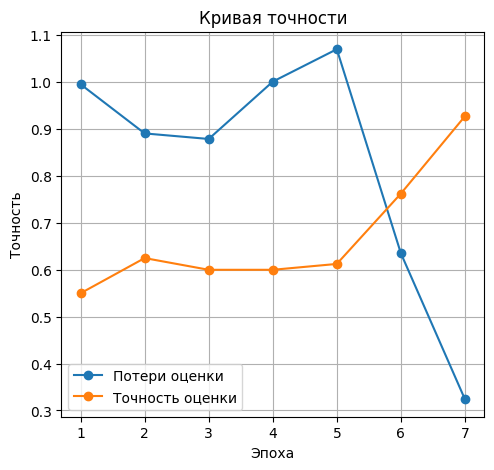

In [97]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_losses, label='Потери оценки', marker='o')  
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Кривая потерь')
plt.legend()
plt.grid(True, alpha=1)

plt.subplot(1, 2, 1)
plt.plot(epochs, eval_acc, label='Точность оценки', marker='o')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Кривая точности')
plt.legend()
plt.grid(True, alpha=1)
plt.show()

In [98]:
import random
print("Примеры предсказаний модели на тесте:")
label_map = {0: 'Негативный', 1: 'Нейтральный', 2: 'Позитивный'}
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=-1)
indices = random.sample(range(len(test_df)), min(5, len(test_df)))
for idx in indices:
    text = test_df.iloc[idx]['title']
    true_label = label_map[test_df.iloc[idx]['label']]
    pred_label = label_map[preds[idx]]
    print(f"Текст: {text} Истинная тональность: {true_label} Предсказанная тональность: {pred_label}")

Примеры предсказаний модели на тесте:


c:\Users\fograwwwr\Desktop\prac 2.0\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Текст: Магнитогорцы не успели за «Трактором» // Клуб из Челябинска сравнял счет в полуфинале Кубка Гагарина Истинная тональность: Позитивный Предсказанная тональность: Позитивный
Текст: Forbes узнал о планах VK заменить Booking и Airbnb Истинная тональность: Позитивный Предсказанная тональность: Позитивный
Текст: Австралия ввела санкции против 39 россиян по делу Магнитского Истинная тональность: Нейтральный Предсказанная тональность: Негативный
Текст: Польша обязала НОВАТЭК передать газовую инфраструктуру Истинная тональность: Негативный Предсказанная тональность: Негативный
Текст: «Коммерсантъ» узнал о передаче «Газпрому» лицензии на турбину Истинная тональность: Нейтральный Предсказанная тональность: Нейтральный
